# Import Library

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import warnings
import os, shutil
os.listdir()

from zipfile import ZipFile
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

Mengimport beberapa library yang dibutuhkan dalam proyek.

In [ ]:
warnings.filterwarnings("ignore")

Menonaktifkan semua peringatan

# Load Dataset

Dataset ini diunduh dari Kaggle. Untuk menyambungkan Google Colaboratory dengan Kaggle digunakan perantara Gdrive. File kaggle.json disimpan dalam folder Gdrive yang nantinya akan dipanggil (untuk mengamankan keyword dari file .json).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Untuk mengakses data yang disimpan di Google Drive

In [ ]:
# Buat direktori .kaggle
os.makedirs("/root/.kaggle", exist_ok=True)

# Copy file dari Google Drive
shutil.copy("/content/drive/MyDrive/kaggle/kaggle.json", "/root/.kaggle/kaggle.json")

# Ubah permission-nya
os.chmod("/root/.kaggle/kaggle.json", 600)

1. Membuat folder .kaggle: os.makedirs() membuat folder tersembunyi ini jika belum ada. Folder ini akan menyimpan konfigurasi Kaggle.

2. Menyalin file kaggle.json: shutil.copy() menyalin file kaggle.json yang berisi kredensial Kaggle Anda (dari Google Drive) ke folder .kaggle.

3. Mengatur izin akses: os.chmod() mengubah izin file kaggle.json agar hanya bisa diakses oleh pemiliknya (root), demi keamanan.

In [ ]:
!kaggle datasets download -d nicoletacilibiu/movies-and-ratings-for-recommendation-system

Dataset URL: https://www.kaggle.com/datasets/nicoletacilibiu/movies-and-ratings-for-recommendation-system
License(s): CC0-1.0


Download dataset _nicoletacilibiu/movies-and-ratings-for-recommendation-system_ dari Kaggle

In [ ]:
!unzip movies-and-ratings-for-recommendation-system.zip -d movies-and-ratings-for-recommendation-system

Archive:  movies-and-ratings-for-recommendation-system.zip
  inflating: movies-and-ratings-for-recommendation-system/movies.csv  
  inflating: movies-and-ratings-for-recommendation-system/ratings.csv  


Unzip dataset yang telah didownload

In [ ]:
## Load the data
movies = pd.read_csv('movies-and-ratings-for-recommendation-system/movies.csv')
ratings = pd.read_csv('movies-and-ratings-for-recommendation-system/ratings.csv')

movies : merupakan daftar movie yang tersedia

ratings : merupakan daftar penilaian yang diberikan pengguna terhadap movie.

# Data Understanding

## Explanatory Data Analysis

In [ ]:
print('Jumlah data movie: ', len(movies.movieId.unique()))
print('Jumlah data rating: ', len(ratings.movieId.unique()))

Jumlah data movie:  9742
Jumlah data rating:  9724


Hasil jumlah film unik dan jumlah film unik yang telah diberi rating.

### Movie

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Hasil tampilan beberapa baris pertama dari data movie.

In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


movies.csv memiliki 9742 entri. Terdapat tiga variabel di sini, yaitu movieId, title dan genres. movieId merupakan ID movie, title merupakan judul movie sedangkan genres merupakan jenis genre yang ada di movie.

In [ ]:
movies.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


Terdapat toal 9742 data divariabek movieId.

In [ ]:
print('Banyak movie: ', len(movies.movieId.unique()))
print('Judul movie yang dimiliki: ', movies.title.unique())

Banyak movie:  9742
Judul movie yang dimiliki:  ['Toy Story (1995)' 'Jumanji (1995)' 'Grumpier Old Men (1995)' ...
 'Flint (2017)' 'Bungo Stray Dogs: Dead Apple (2018)'
 'Andrew Dice Clay: Dice Rules (1991)']


Terdapat 9742 data movie yang unik.

### Rating

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Hasil tampilan beberapa baris pertama dari data rating

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


ratings.csv memiliki 100836 entri. Terdapat empat variabel di sini, yaitu userId, movieId, rating dan timestamp.

In [ ]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


Dari output di atas, diketahui bahwa nilai maksimum rating adalah 5 dan nilai minimumnya adalah 0. Artinya, skala rating berkisar antara 0 hingga 5.

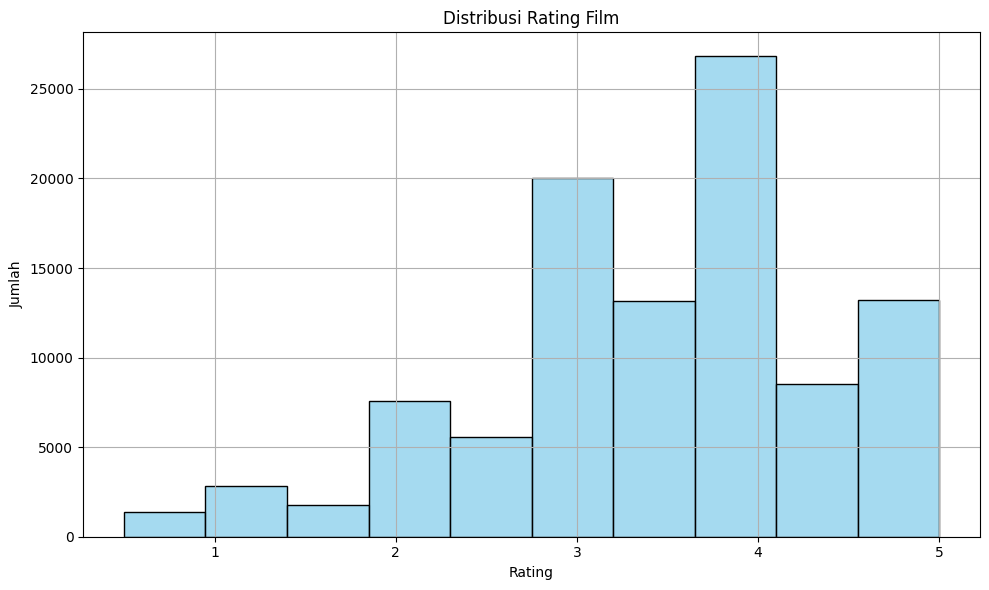

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=ratings, x='rating', bins=10, color='skyblue')

plt.title('Distribusi Rating Film')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.grid(True)
plt.tight_layout()
plt.show()

Dari plot di atas dapat dijelaskan bahwa rating terbanyak ada dikisaran 4. Rating tersebut menunjukkan bahwa data movie yang tersedia merupakan movie yang disukai oleh user.

# Data Prepraration

## Menggabungkan seluruh data

In [ ]:
# Menggabungkan dataframe rating dengan movies berdasarkan nilai movieId
movie = pd.merge(ratings, movies , on='movieId', how='left')

Menggabungkan dua tabel data, yaitu ratings dan movies menjadi satu tabel baru bernama movie. Penggabungan dilakukan berdasarkan kolom movieId yang ada di kedua tabel

In [ ]:
movie.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


Hasil tampilan beberapa baris pertama dari data yang telah digabungkan.

In [ ]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
 4   title      100836 non-null  object 
 5   genres     100836 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 4.6+ MB


Terdapat 6 variabel dari data movie dengan 4 variabel bertipe numerik (userId, movieId, rating, timestamp) dan 2 variabel bertipe string (title, genres).

In [ ]:
movie.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


Dari informasi di atas dapat dijelaskan bahwa minimal rating yang ada adalah 0.5 dan maksimal rating yang ada adalah 5.

In [ ]:
# Mengurutkan movie berdasarkan movieId kemudian memasukkannya ke dalam variabel fix_movie
fix_movie = movie.sort_values('movieId', ascending=True)
fix_movie

,userId,movieId,rating,timestamp,title,genres
6315,43,1,5.0,848993983,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
82207,522,1,3.0,1253344674,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
15041,96,1,5.0,964772990,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
65452,420,1,4.0,1218207191,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
67583,438,1,4.5,1105650469,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
27256,184,193581,4.0,1537109082,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
27257,184,193583,3.5,1537109545,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
27258,184,193585,3.5,1537109805,Flint (2017),Drama
27259,184,193587,3.5,1537110021,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


Data diurutkan secara ascending berdasarkan movieId

In [ ]:
# Mengecek berapa jumlah fix_movie
len(fix_movie.movieId.unique())

9724

Jumlah data uniqe yang dimiliki oleh movieId adalah 9742

In [ ]:
# Membuat variabel preparation yang berisi dataframe fix_movie kemudian mengurutkan berdasarkan movieId
preparation = fix_movie
preparation.sort_values('movieId')

,userId,movieId,rating,timestamp,title,genres
6315,43,1,5.0,848993983,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
24321,169,1,4.5,1059427918,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
51655,334,1,3.5,1225477466,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
29268,201,1,5.0,939801780,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
71435,460,1,4.5,1359177505,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
27256,184,193581,4.0,1537109082,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
27257,184,193583,3.5,1537109545,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
27258,184,193585,3.5,1537109805,Flint (2017),Drama
27259,184,193587,3.5,1537110021,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


Membuat salinan data dari fix_movie ke variabel baru bernama preparation, lalu mengurutkan data dalam preparation berdasarkan kolom movieId. Pengurutan ini dilakukan secara ascending (menaik).

In [ ]:
# Mengonversi data series ‘movieId’ menjadi dalam bentuk list
movie_id = preparation['movieId'].tolist()

# Mengonversi data series ‘Name’ menjadi dalam bentuk list
movie_name = preparation['title'].tolist()

# Mengonversi data series ‘Genre’ menjadi dalam bentuk list
movie_genre = preparation['genres'].tolist()

Variabel movieId, title dan genres dikonversi menjadi dalam bentuk list

In [ ]:
# Membuat dictionary untuk data ‘movie_id’, ‘movie_name’, dan ‘genre’
movie_new = pd.DataFrame({
    'id': movie_id,
    'movie_name': movie_name,
    'genre': movie_genre
})
movie_new

,id,movie_name,genre
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9719,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9720,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9721,193585,Flint (2017),Drama
9722,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


Dictionary yang telah dibuat yaitu movie_new digunakan untuk pemodelan

# Model Development

## Content Based Filtering

In [ ]:
data = movie_new
data.sample(5)

,id,movie_name,genre
5757,31297,Gold Diggers of 1935 (1935),Comedy|Musical
2636,3534,28 Days (2000),Drama
2778,3723,Hamlet (1990),Drama
8069,100068,Comme un chef (2012),Comedy
5995,37844,Roll Bounce (2005),Comedy|Drama|Romance


Menyimpan salinan atau referensi dari DataFrame movie_new ke dalam variabel data

### TF-IDF Vectorizer

In [ ]:
# Inisialisasi TfidfVectorizer
tfidf = TfidfVectorizer()

# Melakukan perhitungan idf pada data genre
tfidf.fit(data['genre'])

TfidfVectorizer()

Mempersiapkan data teks dalam kolom genre agar bisa digunakan dalam Content-Based Filtering dengan teknik TF-IDF (Term Frequency - Inverse Document Frequency)

In [ ]:
# Mapping array dari fitur index integer ke fitur nama
tfidf.get_feature_names_out()

array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'fi', 'film', 'genres',
       'horror', 'imax', 'listed', 'musical', 'mystery', 'no', 'noir',
       'romance', 'sci', 'thriller', 'war', 'western'], dtype=object)

Terdapat 20 jenis genre yang ada

In [ ]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tfidf.fit_transform(data['genre'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(9724, 24)

Perhatikanlah, matriks yang kita miliki berukuran (9724, 22). Nilai 9724 merupakan ukuran data dan 24 merupakan matrik kategori genre

In [ ]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0.        , 0.41681721, 0.51634045, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.51235785, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.57836121, 0.        , 0.8157808 , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

Membuat matriks berisi nilai TF-IDF untuk setiap genre di setiap film.

In [ ]:
# Membuat dataframe untuk melihat tf-idf matrix
# Kolom diisi dengan jenis genre
# Baris diisi dengan nama movie

pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=data.movie_name
).sample(24, axis=1).sample(10, axis=0)

,comedy,documentary,crime,no,fi,sci,drama,adventure,musical,western,...,horror,film,mystery,fantasy,children,action,romance,war,listed,genres
movie_name,,,,,,,,,,,,,,,,,,,,,
Beyond Borders (2003),0.000000,0.0,0.000000,0.0,0.0,0.0,0.334497,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.520824,0.785401,0.0,0.0
What a Girl Wants (2003),0.504636,0.0,0.000000,0.0,0.0,0.0,0.466539,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.726418,0.000000,0.0,0.0
Robin Hood (1973),0.252150,0.0,0.000000,0.0,0.0,0.0,0.000000,0.392873,0.564700,0.0,...,0.0,0.0,0.000000,0.000000,0.475739,0.000000,0.000000,0.000000,0.0,0.0
Wrath of the Titans (2012),0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.410252,0.000000,0.0,...,0.0,0.0,0.000000,0.475439,0.000000,0.360302,0.000000,0.000000,0.0,0.0
Frank (2014),0.418683,0.0,0.000000,0.0,0.0,0.0,0.387076,0.000000,0.000000,0.0,...,0.0,0.0,0.821509,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
"Maiden Heist, The (2009)",0.533449,0.0,0.845832,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
Armour of God (Long xiong hu di) (1987),0.434366,0.0,0.000000,0.0,0.0,0.0,0.000000,0.676783,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.594382,0.000000,0.000000,0.0,0.0
"Pajama Game, The (1957)",0.351632,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.787494,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.506170,0.000000,0.0,0.0
Cry-Baby (1990),0.351632,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.787494,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.506170,0.000000,0.0,0.0


Membuat tabel (dataframe) untuk menampilkan hasil perhitungan TF-IDF

### Cosine Similarity

In [ ]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.81352752, 0.15262722, ..., 0.        , 0.42122062,
        0.26751731],
       [0.81352752, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15262722, 0.        , 1.        , ..., 0.        , 0.        ,
        0.57053212],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.42122062, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.26751731, 0.        , 0.57053212, ..., 0.        , 0.        ,
        1.        ]])

Menghitung kemiripan antar film berdasarkan genre-nya menggunakan representasi vektor TF-IDF

In [ ]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama movie
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['movie_name'], columns=data['movie_name'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap movie
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (9724, 9724)


movie_name,Malèna (2000),"American, The (2010)","Colonel Chabert, Le (1994)",Adam's Rib (1949),Better Off Dead... (1985)
movie_name,,,,,
"Magdalene Sisters, The (2002)",0.334497,0.564576,0.334497,0.000000,0.000000
Battle Planet (2008),0.000000,0.000000,0.000000,0.000000,0.000000
Breathless (1983),0.411389,0.636148,0.411389,0.459270,0.459270
Sorority Boys (2002),0.000000,0.000000,0.000000,0.570532,0.570532
Deadpool (2016),0.000000,0.000000,0.000000,0.172055,0.172055
Into the Blue (2005),0.000000,0.379502,0.000000,0.000000,0.000000
Wiener-Dog (2016),0.000000,0.000000,0.000000,0.570532,0.570532
"Illusionist, The (L'illusionniste) (2010)",0.000000,0.000000,0.000000,0.000000,0.000000
Hard Core Logo (1996),0.227072,0.383260,0.227072,0.418930,0.418930


Melihat nilai similarity antar 10 film terhadap 5 film lainnya secara acak—berguna untuk mengecek distribusi nilai kemiripan

### Mendapatkan Rekomendasi

In [ ]:
def movie_recommendations(nama_movie, similarity_data=cosine_sim_df, items=data[['movie_name', 'genre']], k=5):
    """
    Rekomendasi Movie berdasarkan kemiripan dataframe

    Parameter:
    ---
    nama_movie : tipe data string (str)
                Nama movie (index kemiripan dataframe)
    similarity_data : tipe data pd.DataFrame (object)
                      Kesamaan dataframe, simetrik, dengan resto sebagai
                      indeks dan kolom
    items : tipe data pd.DataFrame (object)
            Mengandung kedua nama dan fitur lainnya yang digunakan untuk mendefinisikan kemiripan
    k : tipe data integer (int)
        Banyaknya jumlah rekomendasi yang diberikan
    ---


    Pada index ini, kita mengambil k dengan nilai similarity terbesar
    pada index matrix yang diberikan (i).
    """


    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,nama_movie].to_numpy().argpartition(
        range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop movie_resto agar movie resto yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(nama_movie, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

Membangun sistem rekomendasi film berbasis konten (Content-Based Filtering) dengan menggunakan kemiripan antar film berdasarkan genre-nya, yang dihitung sebelumnya dengan cosine similarity.

In [ ]:
data[data.movie_name.eq('If I Stay (2014)')]

,id,movie_name,genre
8482,113604,If I Stay (2014),Drama


Mencari data film dengan judul "If I Stay (2014)" di DataFrame data

In [ ]:
# Mendapatkan rekomendasi movie yang mirip dengan If I Stay (2014)
movie_recommendations('If I Stay (2014)')

,movie_name,genre
0,Monsieur Ibrahim (Monsieur Ibrahim et les fleu...,Drama
1,"Legend of 1900, The (a.k.a. The Legend of the ...",Drama
2,Away from Her (2006),Drama
3,Limbo (1999),Drama
4,Kiss of the Spider Woman (1985),Drama


Hasil dari sistem rekomendasi berupa DataFrame berisi daftar film yang mirip dengan "If I Stay (2014)", berdasarkan genre-nya, menggunakan pendekatan Content-Based Filtering (cosine similarity + TF-IDF)

## Collaborative Filtering

In [ ]:
# Membaca dataset
df = ratings
df

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,609,3120
100832,610,168248,5.0,1493850091,609,2035
100833,610,168250,5.0,1494273047,609,3121
100834,610,168252,5.0,1493846352,609,1392


Menampilkan isi dari df, sehingga bisa melihat isi tabel tersebut langsung

### Data Preparation

In [ ]:
# Mengubah userId menjadi list tanpa nilai yang sama
user_ids = df['userId'].unique().tolist()
print('list userId: ', user_ids)

# Melakukan encoding userId
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userId : ', user_to_user_encoded)

# Melakukan proses encoding angka ke ke userID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userId: ', user_encoded_to_user)

list userId:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

Kode di atas berfungsi untuk mengubah dan memetakan userId dalam dataset menjadi angka untuk memudahkan proses dalam model rekomendasi.

In [ ]:
# Mengubah movieId menjadi list tanpa nilai yang sama
movie_ids = df['movieId'].unique().tolist()

# Melakukan proses encoding movieId
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}

# Melakukan proses encoding angka ke movieId
movie_encoded_to_movie = {i: x for i, x in enumerate(movie_ids)}

Kode di atas bertujuan untuk melakukan encoding pada kolom movieId dalam dataset.

In [ ]:
# Mapping userId ke dataframe genre
df['genre'] = df['userId'].map(user_to_user_encoded)

# Mapping movieId ke dataframe movie
df['movie'] = df['movieId'].map(movie_to_movie_encoded)

Kode di atas bertujuan untuk memetakan (mapping) nilai userId dan movieId ke dalam encoding numerik di DataFrame df.

In [ ]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)

# Mendapatkan jumlah movie
num_movie = len(movie_encoded_to_movie)
print(num_movie)

df['rating'] = df['rating'].values.astype(np.float32)

# Nilai minimum rating
min_rating = min(df['rating'])

# Nilai maksimal rating
max_rating = max(df['rating'])

print('Number of User: {}, Number of Movie: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_movie, min_rating, max_rating
))

610
9724
Number of User: 610, Number of Movie: 9724, Min Rating: 0.5, Max Rating: 5.0


Hasil informasi dasar dari dataset film dan rating.

### Splitting Data

In [ ]:
df = df.sample(frac=1, random_state=42)
df

,userId,movieId,rating,timestamp,user,movie,genre
67037,432,77866,4.5,1335139641,431,4730,431
42175,288,474,3.0,978465565,287,474,287
93850,599,4351,3.0,1498524542,598,2631,598
6187,42,2987,4.0,996262677,41,194,41
12229,75,1610,4.0,1158989841,74,727,74
...,...,...,...,...,...,...,...
6265,42,4005,4.0,996259059,41,1873,41
54886,364,141,4.0,869443367,363,524,363
76820,480,6867,4.0,1179163171,479,2240,479
860,6,981,3.0,845556567,5,712,5


Hasil tampilan beberapa baris pertama dari data df.

In [ ]:
# Membuat variabel x untuk mencocokkan data user dan movie menjadi satu value
x = df[['genre', 'movie']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

Kode di atas bertujuan untuk menyiapkan data untuk proses pelatihan model dengan dua variabel utama: x untuk fitur dan y untuk target/label.

In [ ]:
# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[ 431 4730]
 [ 287  474]
 [ 598 2631]
 ...
 [ 479 2240]
 [   5  712]
 [ 102 2046]] [0.88888889 0.55555556 0.55555556 ... 0.77777778 0.55555556 1.        ]


Data dibagi menjadi 80% data training dan 20% data validasi/testing

### Training Data

In [ ]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_movie, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movie = num_movie
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.movie_embedding = layers.Embedding( # layer embeddings movie
        num_movie,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.movie_bias = layers.Embedding(num_movie, 1) # layer embedding movie bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    movie_vector = self.movie_embedding(inputs[:, 1]) # memanggil layer embedding 3
    movie_bias = self.movie_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)

    x = dot_user_movie + user_bias + movie_bias

    return tf.nn.sigmoid(x) # activation sigmoid

Kode yang diberikan mendefinisikan sebuah kelas model jaringan saraf untuk sistem rekomendasi yang disebut RecommenderNet, yang menggunakan embedding untuk pengguna dan film.

In [ ]:
model = RecommenderNet(num_users, num_movie, 50) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Model ini menggunakan Binary Crossentropy untuk menghitung loss function, Adam (Adaptive Moment Estimation) sebagai optimizer, dan root mean squared error (RMSE) sebagai metrics evaluation.

In [ ]:
# Memulai training
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 128,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.6357 - root_mean_squared_error: 0.2297 - val_loss: 0.6356 - val_root_mean_squared_error: 0.2300
Epoch 2/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.6404 - root_mean_squared_error: 0.2333 - val_loss: 0.6302 - val_root_mean_squared_error: 0.2243
Epoch 3/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.6362 - root_mean_squared_error: 0.2292 - val_loss: 0.6298 - val_root_mean_squared_error: 0.2238
Epoch 4/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.6380 - root_mean_squared_error: 0.2302 - val_loss: 0.6300 - val_root_mean_squared_error: 0.2240
Epoch 5/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.6323 - root_mean_squared_error: 0.2270 - val_loss: 0.6244 - val_root_mean_squared_error: 0.2180
Epoch 6/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.6262 - root_mean_squared_error: 0.2179 - val_loss: 0.6269 - val_root_mean_squared_error: 0.2207
Epoch 7/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 5s

1. x = x_train dan y = y_train: Model dilatih menggunakan data fitur (x_train) dan data target (y_train).

2. batch_size = 128: Data diproses dalam kelompok 128 data per iterasi.

3. epochs = 100: Model akan "melihat" seluruh data sebanyak 100 kali selama proses pelatihan.

4. validation_data = (x_val, y_val): Model dievaluasi secara berkala dengan data validasi untuk memantau kinerjanya dan mencegah overfitting.

### Visualisasi Metrics

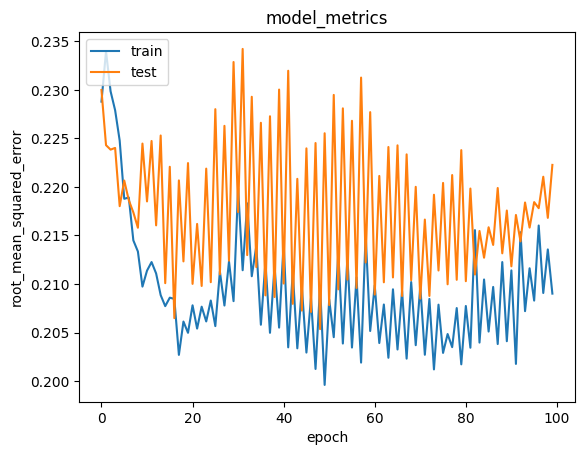

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Dari plot di atas dapat dilihat bahwa hasil rmse antara train dan test tidak begitu jauh.

In [ ]:
# Ambil nilai RMSE terakhir
rmse_train = history.history['root_mean_squared_error'][-1]
rmse_val = history.history['val_root_mean_squared_error'][-1]

# Tampilkan nilai
print(f"RMSE Train (epoch terakhir): {rmse_train:.4f}")
print(f"RMSE Val (epoch terakhir): {rmse_val:.4f}")

RMSE Train (epoch terakhir): 0.2090
RMSE Val (epoch terakhir): 0.2223


Mengambil nilai RMSE (Root Mean Squared Error) dari data training dan validasi setelah proses pelatihan model selesai. Hasil nilai RMSE Train adalah 0.2090 dan RMSE Val adalah 0.2223.

### Mendapatkan Rekomendasi Movie

In [ ]:
movie_df = movie_new
df = pd.read_csv('movies-and-ratings-for-recommendation-system/ratings.csv')

Mempersiapkan dua DataFrame: satu berisi informasi film (movie_df) dan satu lagi berisi rating pengguna (df) untuk digunakan dalam proses rekomendasi film selanjutnya

In [ ]:
# Mengambil sample user
user_id = df.userId.sample(1).iloc[0]
movie_on_by_user = df[df.userId == user_id]

# Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html
movie_off = movie_df[~movie_df['id'].isin(movie_on_by_user.movieId.values)]['id']
movie_off = list(
    set(movie_off)
    .intersection(set(movie_to_movie_encoded.keys()))
)

movie_off = [[movie_to_movie_encoded.get(x)] for x in movie_off]
user_encoder = user_to_user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movie_off), movie_off)
)

Memilih satu pengguna acak (user_id) dan membuat daftar film yang belum pernah ditonton oleh pengguna tersebut (movie_off). Daftar ini kemudian akan digunakan untuk menghasilkan rekomendasi film baru bagi pengguna tersebut.

In [ ]:
ratings = model.predict(user_movie_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded_to_movie.get(movie_off[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Movie with high ratings from user')
print('----' * 8)

top_movie_user = (
    movie_on_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)

movie_df_rows = movie_df[movie_df['id'].isin(top_movie_user)]
for row in movie_df_rows.itertuples():
    print(row.movie_name, ':', row.genre)

print('----' * 8)
print('Top 10 Movie recommendation')
print('----' * 8)

recommended_movie = movie_df[movie_df['id'].isin(recommended_movie_ids)]
for row in recommended_movie.itertuples():
    print(row.movie_name, ':', row.genre)

265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Showing recommendations for users: 68
Movie with high ratings from user
--------------------------------
Star Wars: Episode IV - A New Hope (1977) : Action|Adventure|Sci-Fi
Sin City (2005) : Action|Crime|Film-Noir|Mystery|Thriller
Harry Potter and the Goblet of Fire (2005) : Adventure|Fantasy|Thriller|IMAX
Thank You for Smoking (2006) : Comedy|Drama
Star Trek Into Darkness (2013) : Action|Adventure|Sci-Fi|IMAX
--------------------------------
Top 10 Movie recommendation
--------------------------------
Heidi Fleiss: Hollywood Madam (1995) : Documentary
Paths of Glory (1957) : Drama|War
Jonah Who Will Be 25 in the Year 2000 (Jonas qui aura 25 ans en l'an 2000) (1976) : Comedy
Stunt Man, The (1980) : Action|Adventure|Comedy|Drama|Romance|Thriller
Belle époque (1992) : Comedy|Romance
Trial, The (Procès, Le) (1962) : Drama
Adam's Rib (1949) : Comedy|Romance
Bad Boy Bubby (1993) : Drama
Enter the Void (2009) : Drama
Brooklyn (2015) : Drama|Romance


Informasi di atas merupakan hasil rekomendasi dari collaborative filtering. Terdapat 10 top movie yang direkomendasikan, sesuai dengan movie dengan rating tertinggi dari user.